**Описание проекта**

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

  * сalls — количество звонков,
  * minutes — суммарная длительность звонков в минутах,
  * messages — количество sms-сообщений,
  * mb_used — израсходованный интернет-трафик в Мб,
  * is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import dump
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
df = pd.read_csv('/datasets/users_behavior.csv', decimal = ',')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   calls     3214 non-null   object
 1   minutes   3214 non-null   object
 2   messages  3214 non-null   object
 3   mb_used   3214 non-null   object
 4   is_ultra  3214 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 125.7+ KB


In [ ]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.8999999999999,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.6600000000001,86.0,21060.449999999997,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.750000000002,0


In [ ]:
print('колличество клиентов с тарифом ультра', df['is_ultra'].sum())
print('колличество клиентов', df['is_ultra'].count())
print('процент клиентов с тарифом ультра', round(df['is_ultra'].sum()*100/df['is_ultra'].count(), 2))

колличество клиентов с тарифом ультра 985
колличество клиентов 3214
процент клиентов с тарифом ультра 30.65


In [ ]:
df['calls'] = pd.to_numeric(df['calls'])
df['minutes'] = pd.to_numeric(df['minutes'])
df['messages'] = pd.to_numeric(df['messages'])
df['mb_used'] = pd.to_numeric(df['mb_used'])

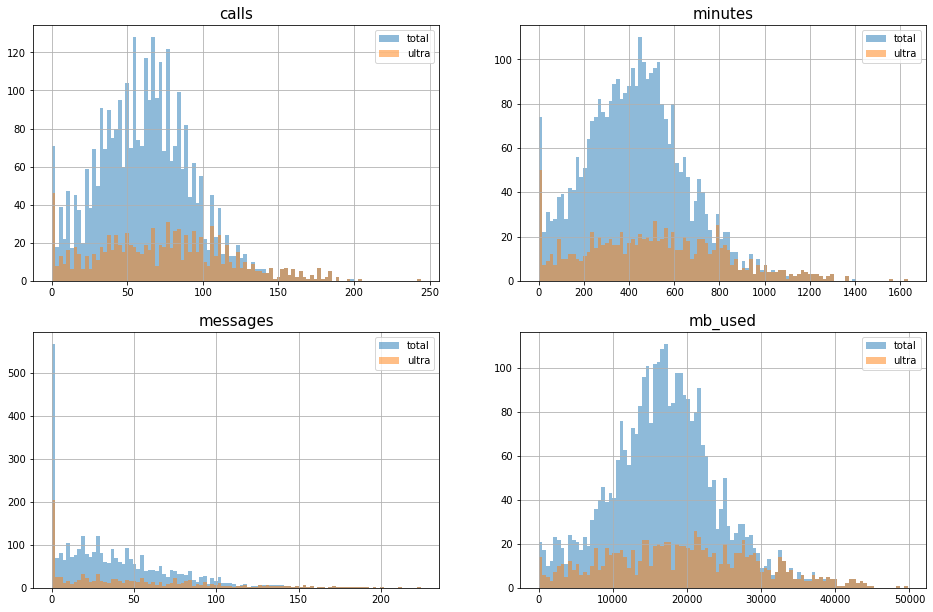

In [ ]:
# Настройка размеров подложки
plt.figure(figsize=(16, 16))

# Вывод графиков
plt.subplot(3, 2, 1)
df['calls'].hist(bins=100, alpha=0.5, label='total')
df[df.is_ultra == 1]['calls'].hist(bins=100, alpha=0.5, label='ultra')
plt.title('calls', fontsize=15)
plt.legend()

plt.subplot(3, 2, 2)
df['minutes'].hist(bins=100, alpha=0.5, label='total')
df[df.is_ultra == 1]['minutes'].hist(bins=100, alpha=0.5, label='ultra')
plt.title('minutes', fontsize=15)
plt.legend()

plt.subplot(3, 2, 3)
df['messages'].hist(bins=100, alpha=0.5, label='total')
df[df.is_ultra == 1]['messages'].hist(bins=100, alpha=0.5, label='ultra')
plt.title('messages', fontsize=15)
plt.legend()

plt.subplot(3, 2, 4)
df['mb_used'].hist(bins=100, alpha=0.5, label='total')
df[df.is_ultra == 1]['mb_used'].hist(bins=100, alpha=0.5,label='ultra')
plt.title('mb_used', fontsize=15)
plt.legend()

 Клиенты с тарифом ультра сильнее распределены по объему использемых параметров. Остальные клиенты группируются лишь на первой половине этой шкалы.


In [ ]:
df_stat=pd.DataFrame({'option':['mean in ultra','total mean','median in ultra','total median'],'calls':[0,0,0,0],'minutes':[0,0,0,0],'messages':[0,0,0,0],'mb_used':[0,0,0,0]})

for option in ('calls','minutes','messages','mb_used'):
    df_stat.loc[0, option] = df[df.is_ultra == 1][option].mean()
    df_stat.loc[1, option] = df[option].mean()
    df_stat.loc[2, option] = df[df.is_ultra == 1][option].median()
    df_stat.loc[3, option] = df[option].median()

In [ ]:
df_stat

,option,calls,minutes,messages,mb_used
0,mean in ultra,73.392893,511.224569,49.363452,19468.823228
1,total mean,63.038892,438.208787,38.281269,17207.673836
2,median in ultra,74.000000,502.550000,38.000000,19308.010000
3,total median,62.000000,430.600000,30.000000,16943.235000


## Разбейте данные на выборки

In [ ]:
df_80, df_test = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_80, test_size=0.25, random_state=12345)

features_test = df_test[['calls', 'minutes', 'messages', 'mb_used']]
target_test = df_test['is_ultra']
features_train = df_train[['calls', 'minutes', 'messages', 'mb_used']]
target_train = df_train['is_ultra']
features_valid = df_valid[['calls', 'minutes', 'messages', 'mb_used']]
target_valid = df_valid['is_ultra']

Не знаю как делить выборку сразу на 3 части, поэтому взяла 20% от отбщей части под тестовую выборку, а потом еще 25% от отстатка на валидационную. Так получила соотношение частей 3:1:1 относительно первоначальных данных

## Исследуйте модели

In [ ]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 7):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model_tree.fit(features_train, target_train) # обучите модель
    predictions_valid_tree = model_tree.predict(features_valid)
    result_tree = accuracy_score(target_valid, predictions_valid_tree) # посчитайте качество модели
    if result_tree > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        
print("Accuracy лучшей модели:", best_result_tree)
print("Depth лучшей модели:", best_depth_tree)

Accuracy лучшей модели: 0.7651632970451011
Depth лучшей модели: 3


In [ ]:
best_model_forest = None
best_result_forest = 0
for est in range(1, 11):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
    model_forest.fit(features_train,target_train) # обучите модель на тренировочной выборке
    result_forest = model_forest.score(features_valid,target_valid) # посчитайте качество модели на валидационной выборке
    if result_forest > best_result_forest:
        best_model_forest = model_forest # сохраните наилучшую модель
        best_result_forest = result_forest #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_est_forest = est # 

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest)
print("Est наилучшей модели на валидационной выборке:", best_est_forest)

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566
Est наилучшей модели на валидационной выборке: 10


In [ ]:
model_linear = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_linear.fit(features_train,target_train) 
result_linear = model_linear.score(features_valid, target_valid) 

print("Accuracy модели:", result_linear)

Accuracy модели: 0.7262830482115086


Из всех моделей луше всего себя показала модель случайного леса с процентом правельных ответов 78,85. Достаточно близка оказалась модель решающего дерева и совсем не прошла порог в 75% линейная модель.

Так как далее у меня возникли сложности с результатами по тестовой выборке при random_state=12345 (Accuracy решающего дерева = Accuracy случайного леса) решила провести тест - запустить эти же модели при random_state=0. Интересно, что Accuracy решающего дерева не изменилось.

In [ ]:
best_model_tree_0 = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 7):
    model_tree = DecisionTreeClassifier(random_state=0, max_depth=depth) # обучите модель с заданной глубиной дерева
    model_tree.fit(features_train, target_train) # обучите модель
    predictions_valid_tree = model_tree.predict(features_valid)
    result_tree = accuracy_score(target_valid, predictions_valid_tree) # посчитайте качество модели
    if result_tree > best_result_tree:
        best_model_tree_0 = model_tree
        best_result_tree = result_tree
        best_depth_tree = depth
        
print("Accuracy лучшей модели:", best_result_tree)
print("Depth лучшей модели:", best_depth_tree)

Accuracy лучшей модели: 0.7651632970451011
Depth лучшей модели: 3


In [ ]:
best_model_forest_0 = None
best_result_forest = 0
for est in range(1, 11):
    model_forest = RandomForestClassifier(random_state=0, n_estimators=est) # обучите модель с заданным количеством деревьев
    model_forest.fit(features_train,target_train) # обучите модель на тренировочной выборке
    result_forest = model_forest.score(features_valid,target_valid) # посчитайте качество модели на валидационной выборке
    if result_forest > best_result_forest:
        best_model_forest_0 = model_forest # сохраните наилучшую модель
        best_result_forest = result_forest #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_est_forest = est # 

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest)
print("Est наилучшей модели на валидационной выборке:", best_est_forest)

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625
Est наилучшей модели на валидационной выборке: 10


## Проверьте модель на тестовой выборке

проверка моделей с random_state=12345

In [ ]:
predictions_tree_test = best_model_tree.predict(features_test)
result_tree_test = accuracy_score(target_test, predictions_tree_test) # посчитайте качество модели
        
print("Accuracy тестовой модели решающего дерева:", result_tree_test)

Accuracy тестовой модели решающего дерева: 0.7869362363919129


In [ ]:
result_forest_test = best_model_forest.score(features_test,target_test) # посчитайте качество модели на валидационной выборке

print("Accuracy тестовой модели случайный лес:", result_forest_test)

Accuracy тестовой модели случайный лес: 0.7869362363919129


In [ ]:
result_linear_test = model_linear.score(features_test, target_test) 

print("Accuracy модели:", result_linear_test)

Accuracy модели: 0.7589424572317263


В этот раз все модели преодолели пороговой значение в 75%.

Как видно из расчетов Accuracy решающего дерева = Accuracy случайного леса на тестовой выборке, мне показалось это весьма странным. Проверяя на Accuracy на random_state = 0, видим раззнае результаты между моделями. Однако ситуация с результатом по решающему дереву повторяется - результат стабилен к изменениям random_state.

Так же интересно, что модель случайного леса показала себя хуже на тестовой выборке, чем решающее дерево (см. random_state=0)

проверка моделей с random_state=0

In [ ]:
predictions_tree_test_0 = best_model_tree_0.predict(features_test)
result_tree_test_0 = accuracy_score(target_test, predictions_tree_test_0) # посчитайте качество модели
        
print("Accuracy тестовой модели решающего дерева:", result_tree_test_0)

Accuracy тестовой модели решающего дерева: 0.7869362363919129


In [ ]:
result_forest_test_0 = best_model_forest_0.score(features_test,target_test) # посчитайте качество модели на валидационной выборке

print("Accuracy тестовой модели случайный лес:", result_forest_test_0)

Accuracy тестовой модели случайный лес: 0.7744945567651633


## (бонус) Проверьте модели на адекватность

In [ ]:
predictions_test_tree = best_model_tree.predict(features_test)
predictions_test_forest = best_model_forest.predict(features_test)
predictions_test_linear = model_linear.predict(features_test)

print('доля тарифов ультра, отмеченных моделью решающего дерева правильно', precision_score(target_test, predictions_test_tree, average='binary'))
print('доля тарифов ультра, отмеченных моделью случайного леса правильно', precision_score(target_test, predictions_test_forest, average='binary'))
print('доля тарифов ультра, отмеченных линейной моделью правильно', precision_score(target_test, predictions_test_linear, average='binary'))


доля тарифов ультра, отмеченных моделью решающего дерева правильно 0.7521367521367521
доля тарифов ультра, отмеченных моделью случайного леса правильно 0.7092198581560284
доля тарифов ультра, отмеченных линейной моделью правильно 0.8867924528301887


In [ ]:
print('полнота отмеченных тарифов ультра, моделью решающего дерева', recall_score(target_test, predictions_test_tree, average='binary'))
print('полнота отмеченных тарифов ультра, моделью случайного леса', recall_score(target_test, predictions_test_forest, average='binary'))
print('полнота отмеченных тарифов ультра, линейной моделью', recall_score(target_test, predictions_test_linear, average='binary'))


полнота отмеченных тарифов ультра, моделью решающего дерева 0.4489795918367347
полнота отмеченных тарифов ультра, моделью случайного леса 0.5102040816326531
полнота отмеченных тарифов ультра, линейной моделью 0.23979591836734693


По доле правильно отмеченного тарифа ультра лидирует линейная модель, роблема лишь в том, что просиходит это довольно редко: полнота заполнения составляет всего 24%. Остальные модели тоже показали невысокий результат заполнения этого тарифа. 

## Вывод

На имеющихся данных лучше всего себя показала модель случайного леса с показателями качества: 

    Accuracy - 0.788, precision - 0.709 и recall - 0.51 
    
На втором месте модель решающего дерева с показателями качества: 

    Accuracy - 0.765, precision - 0.752 и recall - 0.449 
    
И хуже всех отработала линейная модель с показателями качества: 

    Accuracy - 0.726, precision - 0.887 и recall - 0.24